In [1]:
# load those needed libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# load the nvidia stock price dataset
nvidia_df = pd.read_csv('nvidia_stock_price.csv')

/Users/ngkokteng/PycharmProjects/NVIDIA stock prediction/.venv/lib/python3.9/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


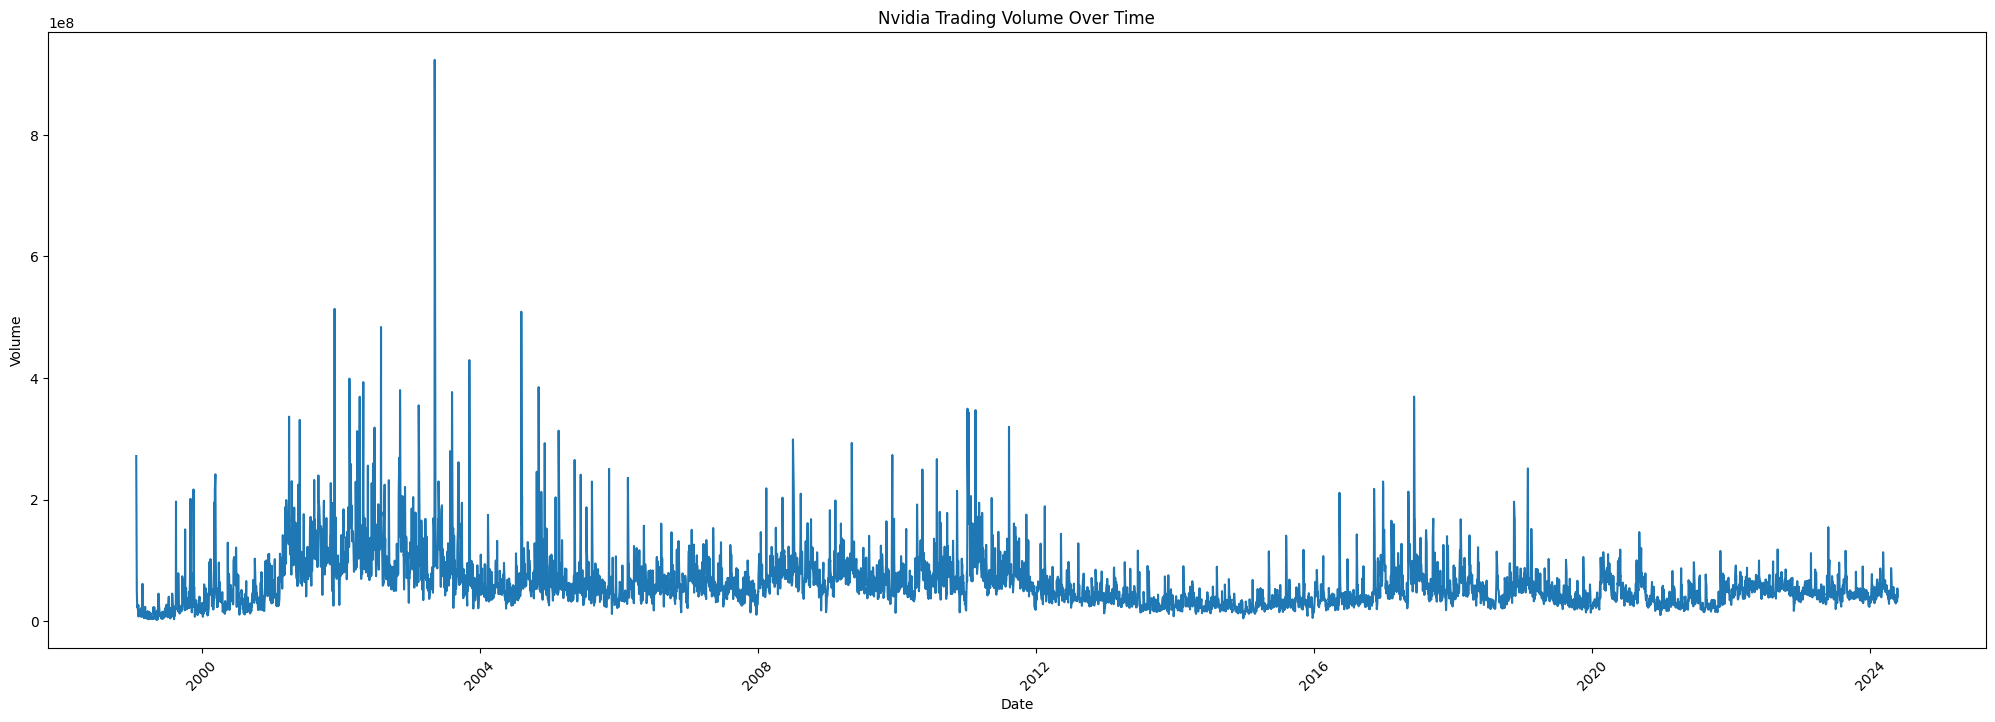

In [2]:
nvidia_df["Date"] = pd.to_datetime(nvidia_df["Date"])

plt.figure(figsize = (25, 8))
plt.plot(nvidia_df["Date"], nvidia_df["Volume"])
plt.title("Nvidia Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base = 4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation = 45)

plt.show()

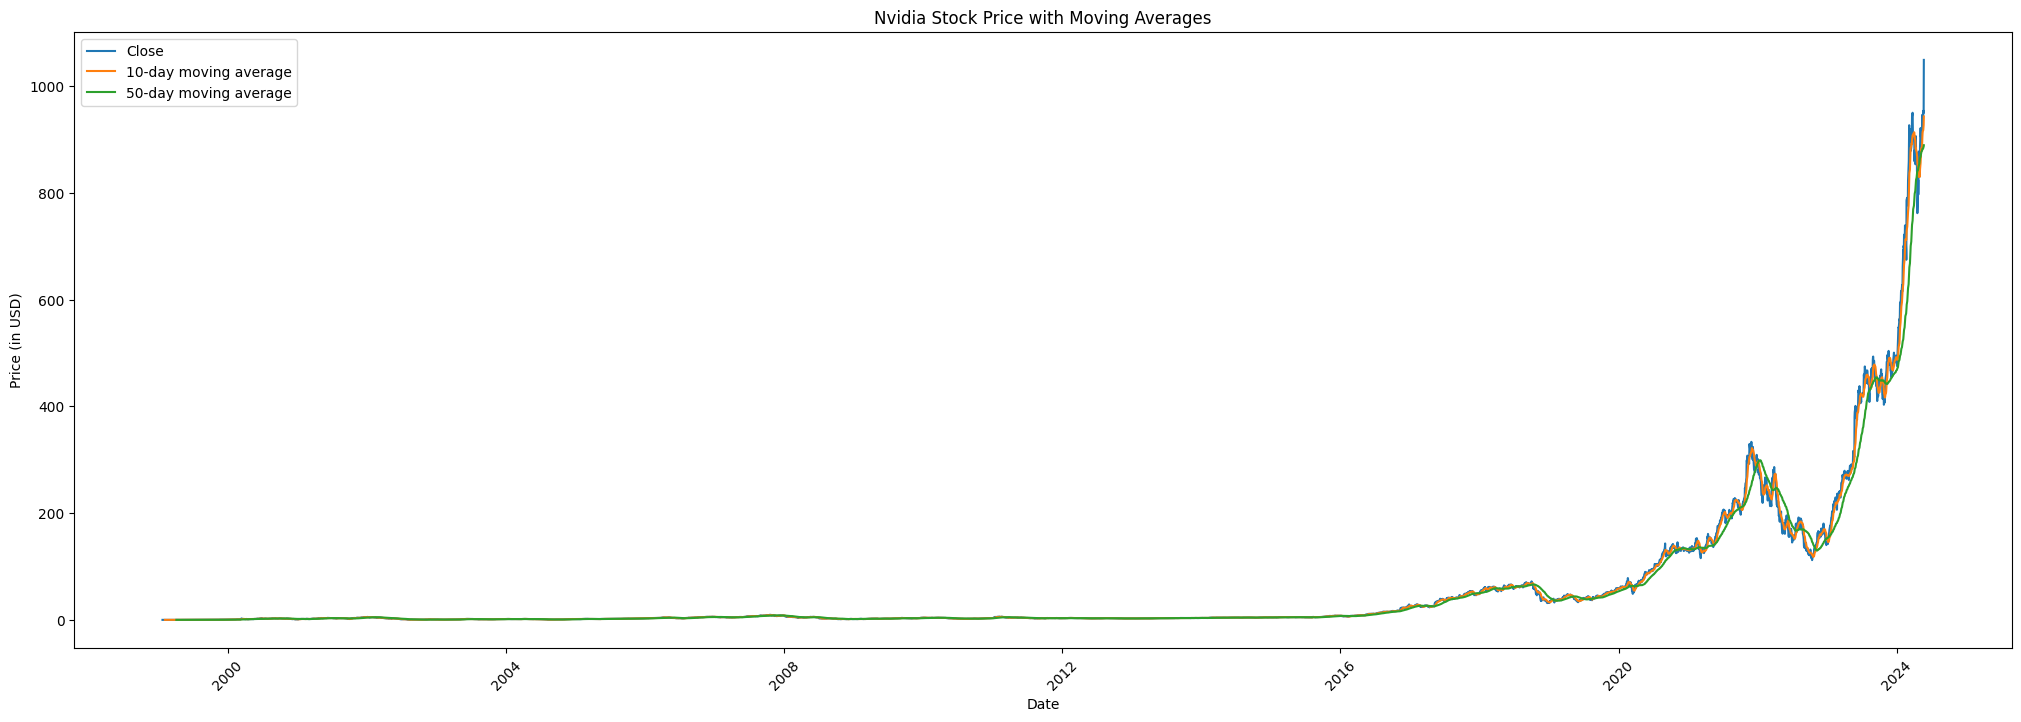

In [3]:
nvidia_df["MA10"] = nvidia_df["Close"].rolling(window = 10).mean()
nvidia_df["MA50"] = nvidia_df["Close"].rolling(window = 50).mean()

plt.figure(figsize = (25, 8))
plt.plot(nvidia_df["Date"], nvidia_df["Close"], label = "Close")
plt.plot(nvidia_df["Date"], nvidia_df["MA10"], label = "10-day moving average")
plt.plot(nvidia_df["Date"], nvidia_df["MA50"], label = "50-day moving average")
plt.title("Nvidia Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.legend(loc = "best")

# Format x-ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base = 4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation = 45)

plt.show()

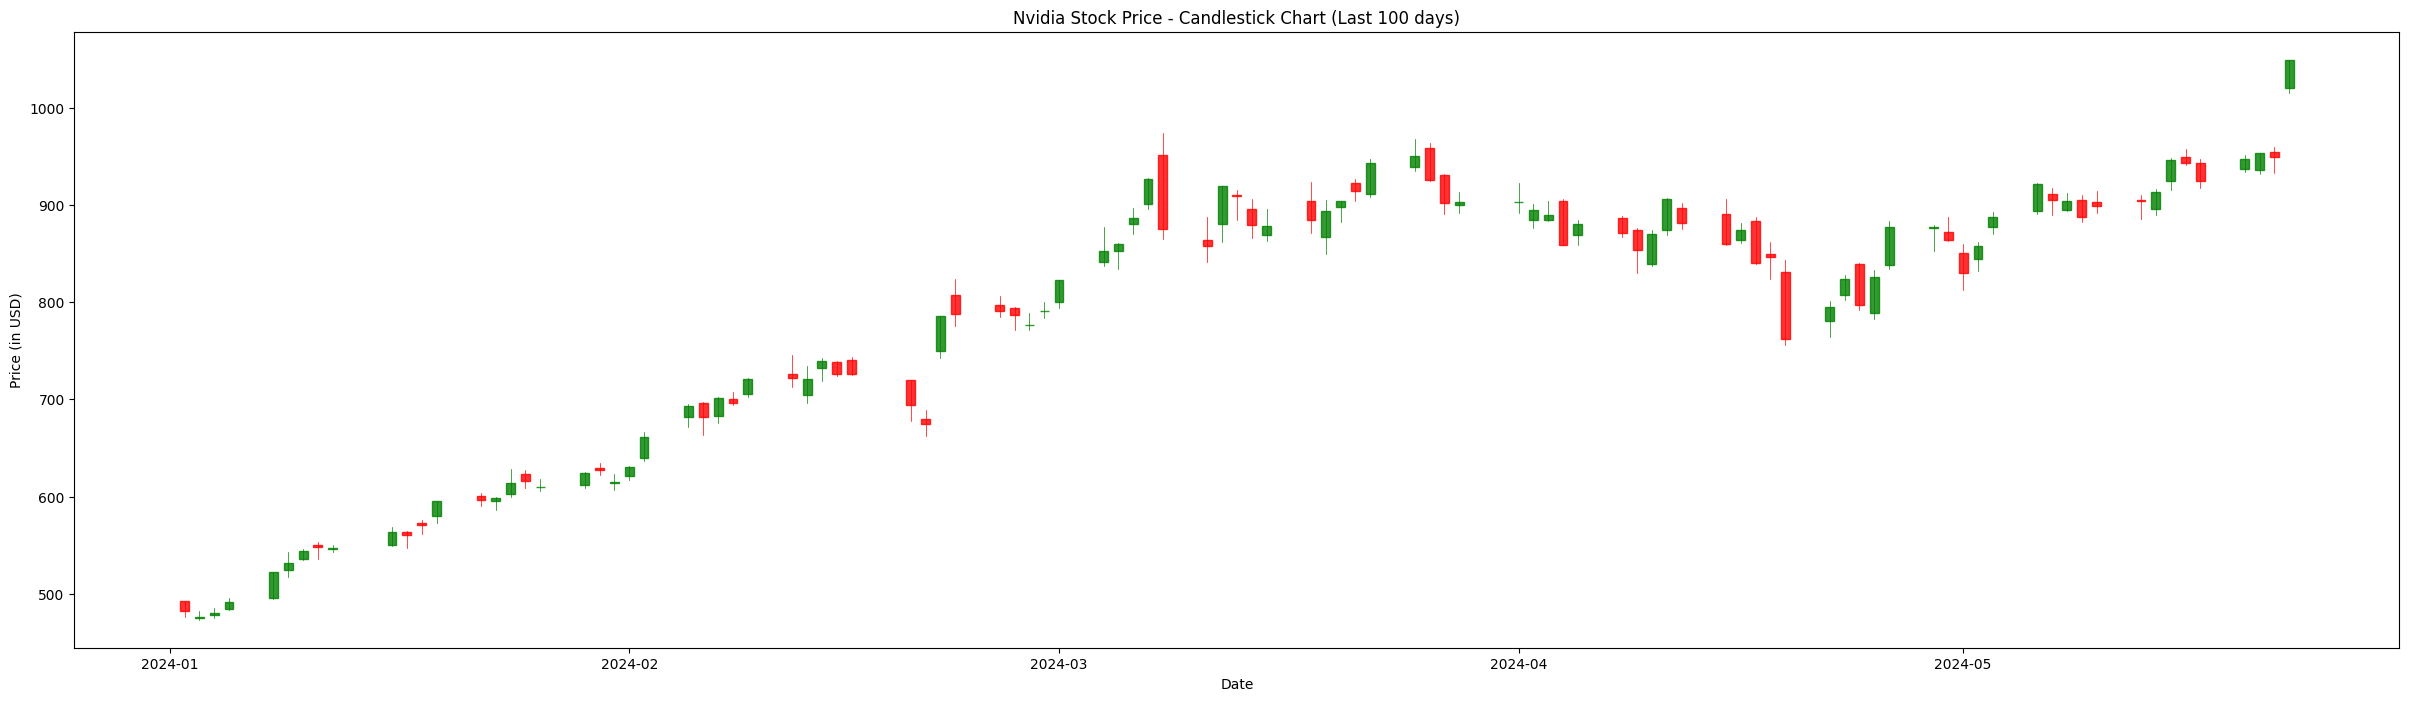

In [4]:
nvidia_df_last_100 = nvidia_df[-100:].copy()
nvidia_df_last_100["Date"] = nvidia_df_last_100["Date"].map(mdates.date2num)
ohlc = nvidia_df_last_100[["Date", "Open", "High", "Low", "Close"]].values

fig, ax = plt.subplots(figsize = (30, 8))
candlestick_ohlc(ax, ohlc, width = 0.6, colorup = "green", colordown = "red", alpha = 0.8)
ax.xaxis_date()
plt.title("Nvidia Stock Price - Candlestick Chart (Last 100 days)")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.show()

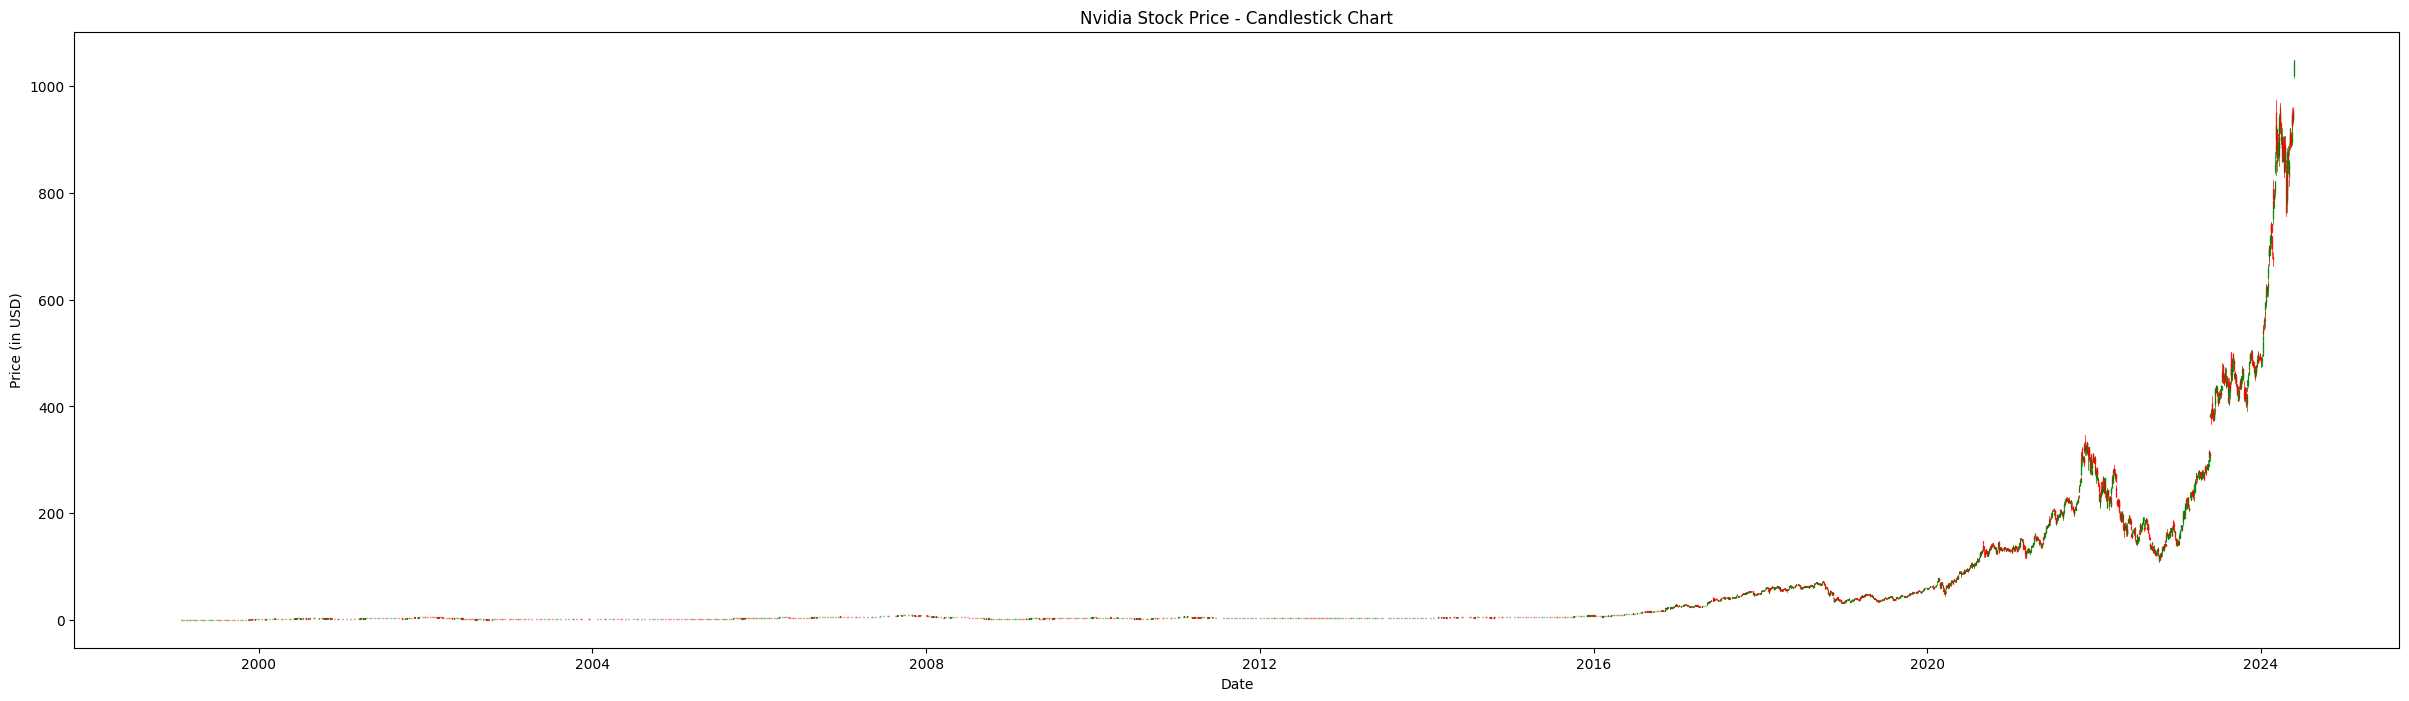

In [5]:
nvidia_df["Date"] = pd.to_datetime(nvidia_df["Date"])
nvidia_df["Date"] = nvidia_df["Date"].apply(mdates.date2num)
ohlc = nvidia_df[["Date", "Open", "High", "Low", "Close"]].values
fig, ax = plt.subplots(figsize = (30, 8))
candlestick_ohlc(ax, ohlc, width = 0.6, colorup = "green", colordown = "red", alpha = 0.8)
ax.xaxis_date()
plt.title("Nvidia Stock Price - Candlestick Chart")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.show()

###### Predicting Stock Prices with Linear Regression Model (and Moving Averages)

In [6]:
nvidia_df["Price_Up"] = np.where(nvidia_df["Close"].shift(-1) > nvidia_df["Close"], 1, 0)
nvidia_df["Price_Up"] = nvidia_df["Price_Up"].shift(-1)
nvidia_df = nvidia_df.dropna()
X = nvidia_df[["Date", "Close", "Volume", "MA10", "MA50"]]
y = nvidia_df["Close"]

split = int(0.7 * len(nvidia_df))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

lr = LinearRegression()
lr.fit(X_train.drop("Date", axis = 1), y_train)
y_pred = lr.predict(X_test.drop("Date", axis = 1))
y_pred = pd.Series(y_pred, index = y_test.index)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {}".format(mse))

Mean Squared Error: 5.1693853955445795e-26


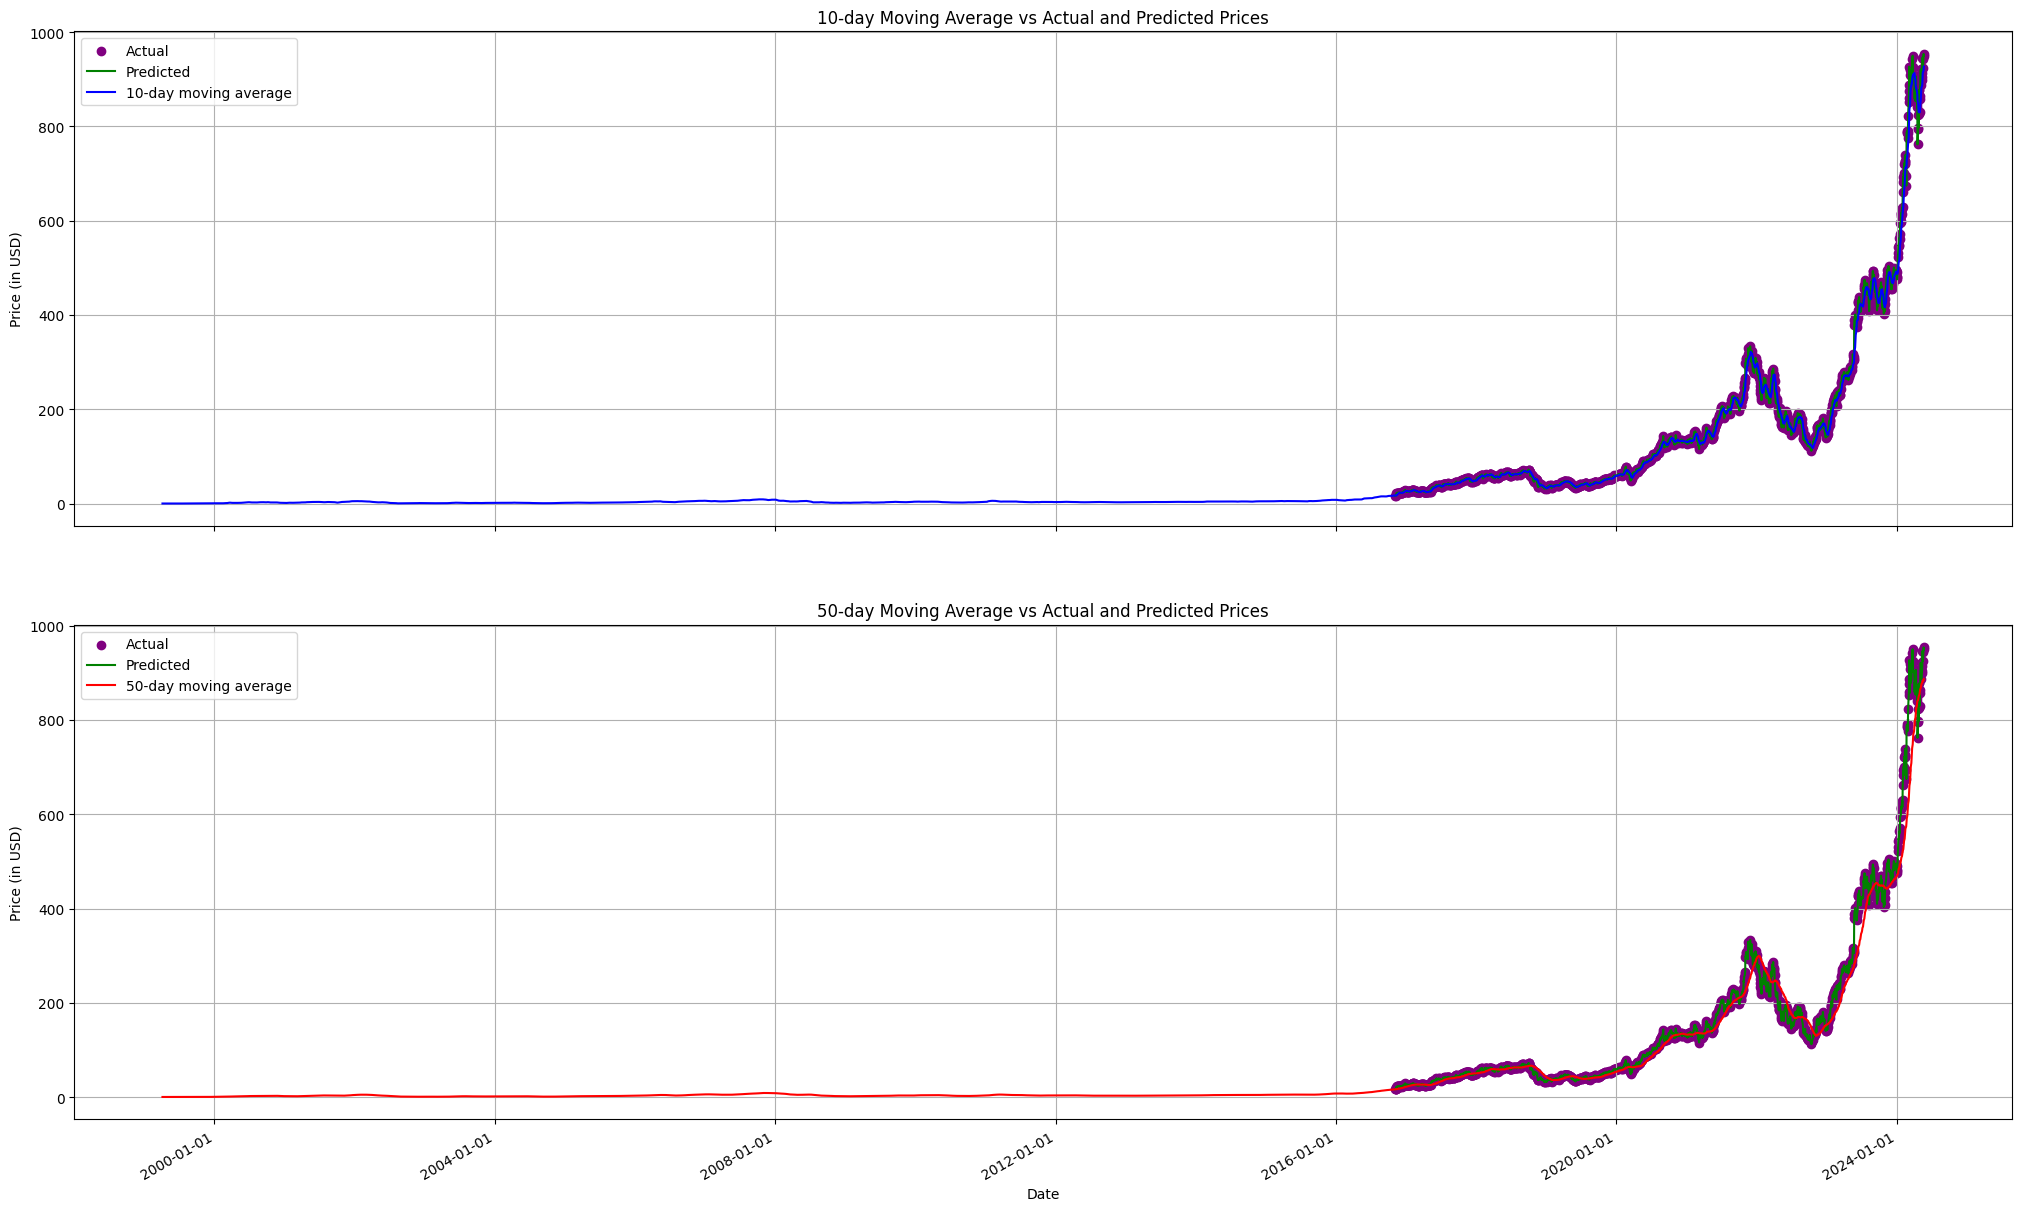

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (25, 16), sharex = True)

ax1.scatter(X_test["Date"], y_test.values, label = "Actual", color = "purple")
ax1.plot(X_test["Date"], y_pred.values, label = "Predicted", color = "green")
ax1.plot(nvidia_df["Date"], nvidia_df["MA10"], label="10-day moving average", color = "blue")
ax1.set_title("10-day Moving Average vs Actual and Predicted Prices")
ax1.set_ylabel("Price (in USD)")
ax1.legend(loc = "best")
ax1.grid(True)

ax2.scatter(X_test["Date"], y_test.values, label = "Actual", color = "purple")
ax2.plot(X_test["Date"], y_pred.values, label = "Predicted", color = "green")
ax2.plot(nvidia_df["Date"], nvidia_df["MA50"], label = "50-day moving average", color = "red")
ax2.set_title("50-day Moving Average vs Actual and Predicted Prices")
ax2.set_xlabel("Date")
ax2.set_ylabel("Price (in USD)")
ax2.legend(loc="best")
ax2.grid(True)

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.YearLocator(base=4))
ax2.xaxis.set_major_locator(mdates.YearLocator(base=4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()